# Case study: re-analysis of zebrafish (*Danio rerio*) single-cell data

This notebook will demonstrate scRNA-seq processing with `orthomap` using Zebrafish scRNA data from ([Farrell et al., 2018](https://doi.org/10.1126/science.aar3131); [Wagner et al., 2018](https://doi.org/10.1126/science.aar4362); [Qiu et al., 2022](https://doi.org/10.1038/s41588-022-01018-x)).

scRNA data were obtained from http://tome.gs.washington.edu/, converted into Scanpy `AnnData` objects ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)) and are availabe here:

https://doi.org/10.5281/zenodo.7243602

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.qiu22_zebrafish(datapath='data')` (download folder set to `'data'`).

## Notebook file

Notebook file can be obtained here:

[https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/zebrafish_example.ipynb](https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/zebrafish_example.ipynb)

## Steps

To process the scRNA data, we will do the following:

0. Run OrthoFinder to obtain orthogroups
1. Get query species taxonomic lineage information
2. Get query species orthomap
3. Map OrthoFinder gene names and scRNA gene/transcript names
4. Get TEI values and add them to scRNA dataset
5. Get partial TEI values to visualize gene age class contributions
6. Process scRNA data and visualize TEI

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
# increase dpi
%matplotlib inline
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.rcParams['figure.figsize'] = [6, 4.5]

## Import orthomap python package submodules

In [2]:
# import submodules
from orthomap import qlin, gtf2t2g, of2orthomap, orthomap2tei, datasets

## step 0 - Run OrthoFinder to obtain orthogroups

`orthomap` can extract gene age classification from existing OrthoFinder results and link them with scRNA data.

A detailed how-to is available here:

https://orthomap.readthedocs.io/en/latest/tutorials/orthofinder.html

However, any pre-calculated gene age classification can be imported as a table using the function `orthomap2tei.read_orthomap(orthomapfile=filename)`.

The pre-calculated gene age classification file should be <tab> delimited with two columns `GeneID<tab>Phylostratum`, like e.g.:
    
```
GeneID<tab>Phylostratum
WBGene00000001<tab>1
WBGene00000002<tab>1
WBGene00000003<tab>1
WBGene00000004<tab>1
WBGene00000005<tab>2
```

OrthoFinder ([Emms and Kelly, 2019](https://doi.org/10.1186/s13059-019-1832-y)) results (-S diamond_ultra_sens) using translated, longest-isoform coding sequences (CDS) from [Ensembl release-105](https://ftp.ensembl.org/pub/release-105/), including species taxonomic IDs, are available here: 

https://doi.org/10.5281/zenodo.7242264

or can be accessed with the `dataset` submodule of `orthomap`:

`datasets.ensembl105(datapath='data')` (download folder set to `'data'`).

In [3]:
datasets.ensembl105(datapath='data')

100% [..............................................................................] 15662 / 15662

['data/ensembl_105_orthofinder_Orthogroups.GeneCount.tsv.zip',
 'data/ensembl_105_orthofinder_Orthogroups.tsv.zip',
 'data/ensembl_105_orthofinder_species_list.tsv']

## step 1 - Get query species taxonomic lineage information

Given a species name or taxonomic ID, the query species lineage information is extracted with the help of the `ete3` python toolkit and the `NCBI taxonomy` ([Huerta-Cepas et al., 2016](https://doi.org/10.1093/molbev/msw046)). This information is needed alongside with the taxonomic classifications for all species used in the OrthoFinder comparison.

The `orthomap` submodule `qlin` helps to get this information for you with the `qlin.get_qlin()` function as follows:

In [4]:
# get query species taxonomic lineage information
query_lineage = qlin.get_qlin(q='Danio rerio')

query name: Danio rerio
query taxID: 7955
query kingdom: Eukaryota
query lineage names: 
['root(1)', 'cellular organisms(131567)', 'Eukaryota(2759)', 'Opisthokonta(33154)', 'Metazoa(33208)', 'Eumetazoa(6072)', 'Bilateria(33213)', 'Deuterostomia(33511)', 'Chordata(7711)', 'Craniata(89593)', 'Vertebrata(7742)', 'Gnathostomata(7776)', 'Teleostomi(117570)', 'Euteleostomi(117571)', 'Actinopterygii(7898)', 'Actinopteri(186623)', 'Neopterygii(41665)', 'Teleostei(32443)', 'Osteoglossocephalai(1489341)', 'Clupeocephala(186625)', 'Otomorpha(186634)', 'Ostariophysi(32519)', 'Otophysi(186626)', 'Cypriniphysae(186627)', 'Cypriniformes(7952)', 'Cyprinoidei(30727)', 'Danionidae(2743709)', 'Danioninae(2743711)', 'Danio(7954)', 'Danio rerio(7955)']
query lineage: 
[1, 131567, 2759, 33154, 33208, 6072, 33213, 33511, 7711, 89593, 7742, 7776, 117570, 117571, 7898, 186623, 41665, 32443, 1489341, 186625, 186634, 32519, 186626, 186627, 7952, 30727, 2743709, 2743711, 7954, 7955]


## step 2 - Get query species orthomap

Here, `orthomap` use the query species information and OrthoFinder results to extract the oldest common tree node per orthogroup along a species tree and to assign this node as the gene age to the corresponding genes.

In a pairwise manner, the query species and any other species in the OrthoFinder result might share multiple tree nodes down to the root of the species tree, but have only one youngest tree node in common. Among all possible comparison between the query species and the other species, the oldest as defined by the species tree root is seected and used for the gene age assignment.

Given the `query species sequence name` (`seqname=`) used in the OrthoFinder comparison, the `query species taxonomic ID`(`qt=`), the `taxonomic IDs of all species` (`sl=`) used in the OrthoFinder comparison, the `orthogroup gene count` (`oc=`) results and the `orthogroups` (`og=`), an orthomap is constructed.

__Note:__ This step can take up to five minutes, depending on your hardware.

For this step to get the query species orthomap, one uses the `of2orthomap.get_orthomap()` function, like:

corresponds to main figure Figure 1B

In [5]:
# get query species orthomap

# download orthofinder results here: https://doi.org/10.5281/zenodo.7242264
# or download with datasets.ensembl105('data')
query_orthomap, orthofinder_species_list, of_species_abundance = of2orthomap.get_orthomap(
    seqname='Danio_rerio.GRCz11.cds.longest',
    qt='7955',
    sl='data/ensembl_105_orthofinder_species_list.tsv',
    oc='data/ensembl_105_orthofinder_Orthogroups.GeneCount.tsv',
    og='data/ensembl_105_orthofinder_Orthogroups.tsv',
    continuity=True)
query_orthomap

Danio_rerio.GRCz11.cds.longest
Danio rerio
7955
                                               species    taxID  \
0    Acanthochromis_polyacanthus.ASM210954v1.cds.lo...    80966   
1    Accipiter_nisus.Accipiter_nisus_ver1.0.cds.lon...   211598   
2       Ailuropoda_melanoleuca.ASM200744v2.cds.longest     9646   
3             Amazona_collaria.ASM394721v1.cds.longest   241587   
4         Amphilophus_citrinellus.Midas_v5.cds.longest    61819   
..                                                 ...      ...   
307  Xiphophorus_couchianus.Xiphophorus_couchianus-...    32473   
308  Xiphophorus_maculatus.X_maculatus-5.0-male.cds...     8083   
309    Zalophus_californianus.mZalCal1.pri.cds.longest     9704   
310  Zonotrichia_albicollis.Zonotrichia_albicollis-...    44394   
311  Zosterops_lateralis_melanops.ASM128173v1.cds.l...  1220523   

                                               lineage  youngest_common  \
0    [1, 131567, 2759, 33154, 33208, 6072, 33213, 3...           186625 

,seqID,Orthogroup,PSnum,PStaxID,PSname,PScontinuity
0,ENSDART00000127643.3,OG0000000,6,33213,Bilateria,0.846154
1,ENSDART00000171750.2,OG0000000,6,33213,Bilateria,0.846154
2,ENSDART00000190648.1,OG0000000,6,33213,Bilateria,0.846154
3,ENSDART00000130167.3,OG0000001,10,7742,Vertebrata,0.909091
4,ENSDART00000150909.2,OG0000001,10,7742,Vertebrata,0.909091
...,...,...,...,...,...,...
25167,ENSDART00000180796.1,OG0029510,19,186625,Clupeocephala,0.400000
25168,ENSDART00000145618.2,OG0029511,19,186625,Clupeocephala,0.400000
25169,ENSDART00000143229.2,OG0029512,29,7955,Danio rerio,1.000000
25170,ENSDART00000143837.3,OG0029512,29,7955,Danio rerio,1.000000


### Gene age assignments per query species lineage node

Given an orthomap, one can get an overview of the gene age assignments per query species lineage node.

The `orthomap` submodule `of2orhomap` and the `of2orthomap.get_counts_per_ps()` function will show the distribution of the gene age classes and can be further visualized as follows:

In [6]:
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(query_orthomap)

,PSnum,counts,PStaxID,PSname
PSnum,,,,
3,3,5209,33154,Opisthokonta
6,6,10495,33213,Bilateria
8,8,2869,7711,Chordata
10,10,2586,7742,Vertebrata
11,11,1257,7776,Gnathostomata
13,13,817,117571,Euteleostomi
14,14,380,7898,Actinopterygii
16,16,184,41665,Neopterygii
18,18,163,1489341,Osteoglossocephalai


### Visualize number of species along query lineage and counts per gene age class

<AxesSubplot: >

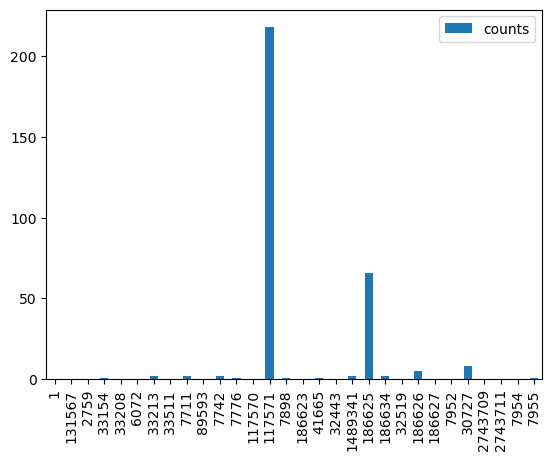

In [7]:
# show number of species along query lineage
of_species_abundance

# bar plot number of species along query lineage
of_species_abundance.plot.bar(y='counts', use_index=True)

corresponds to main figure Figure 1C

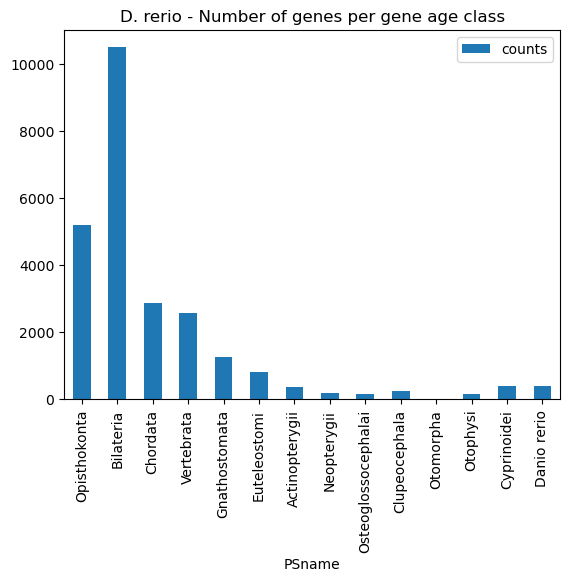

In [8]:
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(query_orthomap)

# bar plot count per taxonomic group (PSname)
ax = of2orthomap.get_counts_per_ps(query_orthomap).plot.bar(y='counts', x='PSname')
ax.set_title('D. rerio - Number of genes per gene age class')
plt.show()

## step 3 - Map OrthoFinder gene names and scRNA gene/transcript names

To be able to link gene ages assignments from an orthomap and gene or transcript of scRNA dataset, one needs to check the overlap of the annotated gene names. With the `gtf2t2g` submodule of `orthomap` and the `gtf2t2g.parse_gtf()` function, one can extract gene and transcript names from a given gene feature file (`GTF`).

In [9]:
# get gene to transcript table for Danio rerio

# https://ftp.ensembl.org/pub/release-105/gtf/danio_rerio/Danio_rerio.GRCz11.105.gtf.gz
query_species_t2g = gtf2t2g.parse_gtf(
    gtf='data/Danio_rerio.GRCz11.105.gtf.gz',
    g=True, b=True, p=True, v=True, s=True, q=True)

32520 gene_id found
59876 transcript_id found
59876 protein_id found
0 duplicated


In [10]:
query_species_t2g

,gene_id,gene_id_version,transcript_id,transcript_id_version,gene_name,gene_type,protein_id,protein_id_version
0,ENSDARG00000000001,ENSDARG00000000001.6,ENSDART00000000004,ENSDART00000000004.5,slc35a5,protein_coding,ENSDARP00000000004,ENSDARP00000000004.2
1,ENSDARG00000000002,ENSDARG00000000002.8,ENSDART00000000005,ENSDART00000000005.7,ccdc80,protein_coding,ENSDARP00000000005,ENSDARP00000000005.6
2,ENSDARG00000000018,ENSDARG00000000018.9,ENSDART00000181044,ENSDART00000181044.1,nrf1,protein_coding,ENSDARP00000149440,ENSDARP00000149440.1
3,ENSDARG00000000018,ENSDARG00000000018.9,ENSDART00000138183,ENSDART00000138183.2,nrf1,protein_coding,ENSDARP00000116798,ENSDARP00000116798.1
4,ENSDARG00000000019,ENSDARG00000000019.9,ENSDART00000124452,ENSDART00000124452.3,ube2h,protein_coding,ENSDARP00000107407,ENSDARP00000107407.2
...,...,...,...,...,...,...,...,...
59871,ENSDARG00000117825,ENSDARG00000117825.1,ENSDART00000194739,ENSDART00000194739.1,CU207269.4,lincRNA,None,None
59872,ENSDARG00000117826,ENSDARG00000117826.1,ENSDART00000194042,ENSDART00000194042.1,CR385041.2,lincRNA,None,None
59873,ENSDARG00000117826,ENSDARG00000117826.1,ENSDART00000194514,ENSDART00000194514.1,CR385041.2,lincRNA,None,None
59874,ENSDARG00000117827,ENSDARG00000117827.1,ENSDART00000194378,ENSDART00000194378.1,CR388164.3,lincRNA,None,None


### Import now, the scRNA dataset of the query species

Here, data is used, like in the publication ([Farrell et al., 2018](https://doi.org/10.1126/science.aar3131); [Wagner et al., 2018](https://doi.org/10.1126/science.aar4362); [Qiu et al., 2022](https://doi.org/10.1038/s41588-022-01018-x)).

scRNA data was downloaded from http://tome.gs.washington.edu/ as R rds files, combined into a single Seurat object and converted into loom and AnnData (h5ad) files to be able to analyse with e.g. python scanpy or orthomap package and is available here:

https://doi.org/10.5281/zenodo.7243602

or can be accessed with the `dataset` submodule of `orthomap`:

`datasets.qiu22_zebrafish(datapath='data')` (download folder set to `'data'`).

In [11]:
# load scRNA data

# download zebrafish scRNA data here: https://doi.org/10.5281/zenodo.7243602
# or download with datasets.qui22_zebrafish(datapath='data')

#zebrafish_data = datasets.qiu22_zebrafish(datapath='data')
zebrafish_data = sc.read('data/zebrafish_data.h5ad')

### Get an overview of observations

In [12]:
zebrafish_data.obs

,orig.ident,nCount_RNA,nFeature_RNA,sample,stage,group,cell_state,cell_type
hpf3.3_ZFHIGH_WT_DS5_AAAAGTTGCCTC,ZFHIGH,5773.0,2570,ZFHIGH_WT_DS5_AAAAGTTGCCTC,hpf3.3,F_3.3,hpf3.3:blastomere,blastomere
hpf3.3_ZFHIGH_WT_DS5_AAACAAGTGTAT,ZFHIGH,2312.0,1451,ZFHIGH_WT_DS5_AAACAAGTGTAT,hpf3.3,F_3.3,hpf3.3:blastomere,blastomere
hpf3.3_ZFHIGH_WT_DS5_AAACACCTCGTC,ZFHIGH,4180.0,2166,ZFHIGH_WT_DS5_AAACACCTCGTC,hpf3.3,F_3.3,hpf3.3:blastomere,blastomere
hpf3.3_ZFHIGH_WT_DS5_AAATGAGGTTTN,ZFHIGH,6686.0,2845,ZFHIGH_WT_DS5_AAATGAGGTTTN,hpf3.3,F_3.3,hpf3.3:blastomere,blastomere
hpf3.3_ZFHIGH_WT_DS5_AACCCTCTCGAT,ZFHIGH,20095.0,4993,ZFHIGH_WT_DS5_AACCCTCTCGAT,hpf3.3,F_3.3,hpf3.3:blastomere,blastomere
...,...,...,...,...,...,...,...,...
hpf24_DEW057_TGACACAACAG_GCCACATC,DEW057,3916.0,1328,DEW057_TGACACAACAG_GCCACATC,hpf24,batch2,hpf24:midbrain,midbrain
hpf24_DEW057_CTTACGGG_AACCTGAC,DEW057,5611.0,1700,DEW057_CTTACGGG_AACCTGAC,hpf24,batch2,hpf24:pharyngeal arch,pharyngeal arch
hpf24_DEW057_TGAACATCTAT_GACGATGG,DEW057,3676.0,1345,DEW057_TGAACATCTAT_GACGATGG,hpf24,batch2,hpf24:midbrain,midbrain
hpf24_DEW057_TGAGGTTTCTC_CTCAGAAT,DEW057,7021.0,1778,DEW057_TGAGGTTTCTC_CTCAGAAT,hpf24,batch2,hpf24:optic cup,optic cup


### Helper functions to match gene names

The `orthomap2tei` submodule contains the `orthomap2tei.geneset_overlap()` helper function to check for gene name overlap between the constructed orthomap from `OrthoFinder` results and a given scRNA dataset.

In [13]:
# check overlap of orthomap <seqID> and scRNA data <var_names>
orthomap2tei.geneset_overlap(zebrafish_data.var_names, query_orthomap['seqID'])

,g1_g2_overlap,g1_ratio,g2_ratio
0,0,0.0,0.0


In [14]:
# check overlap of transcript table <gene_id> and scRNA data <var_names>
orthomap2tei.geneset_overlap(zebrafish_data.var_names, query_species_t2g['gene_id'])

,g1_g2_overlap,g1_ratio,g2_ratio
0,20418,1.0,0.62786


### Reduce isoforms to genes

The `of2orthomap.replace_by()` helper function can be used to add a new column to the orthomap dataframe by matching e.g. gene isoform names and their corresponding gene names.

In [15]:
query_orthomap

,seqID,Orthogroup,PSnum,PStaxID,PSname,PScontinuity
0,ENSDART00000127643.3,OG0000000,6,33213,Bilateria,0.846154
1,ENSDART00000171750.2,OG0000000,6,33213,Bilateria,0.846154
2,ENSDART00000190648.1,OG0000000,6,33213,Bilateria,0.846154
3,ENSDART00000130167.3,OG0000001,10,7742,Vertebrata,0.909091
4,ENSDART00000150909.2,OG0000001,10,7742,Vertebrata,0.909091
...,...,...,...,...,...,...
25167,ENSDART00000180796.1,OG0029510,19,186625,Clupeocephala,0.400000
25168,ENSDART00000145618.2,OG0029511,19,186625,Clupeocephala,0.400000
25169,ENSDART00000143229.2,OG0029512,29,7955,Danio rerio,1.000000
25170,ENSDART00000143837.3,OG0029512,29,7955,Danio rerio,1.000000


In [16]:
zebrafish_data.var_names

Index(['ENSDARG00000002968', 'ENSDARG00000056314', 'ENSDARG00000102274',
       'ENSDARG00000012468', 'ENSDARG00000063621', 'ENSDARG00000044802',
       'ENSDARG00000011410', 'ENSDARG00000041170', 'ENSDARG00000011855',
       'ENSDARG00000103957',
       ...
       'ENSDARG00000078476', 'ENSDARG00000058562', 'ENSDARG00000110745',
       'ENSDARG00000114172', 'ENSDARG00000110433', 'ENSDARG00000098193',
       'ENSDARG00000101137', 'ENSDARG00000095817', 'ENSDARG00000079034',
       'ENSDARG00000063372'],
      dtype='object', name='index', length=20418)

In [17]:
# convert orthomap transcript IDs into GeneIDs and add them to orthomap
query_orthomap['geneID'] = orthomap2tei.replace_by(
    x_orig = query_orthomap['seqID'],
    xmatch = query_species_t2g['transcript_id_version'],
    xreplace = query_species_t2g['gene_id'],
)

In [18]:
query_orthomap

,seqID,Orthogroup,PSnum,PStaxID,PSname,PScontinuity,geneID
0,ENSDART00000127643.3,OG0000000,6,33213,Bilateria,0.846154,ENSDARG00000087544
1,ENSDART00000171750.2,OG0000000,6,33213,Bilateria,0.846154,ENSDARG00000095745
2,ENSDART00000190648.1,OG0000000,6,33213,Bilateria,0.846154,ENSDARG00000097551
3,ENSDART00000130167.3,OG0000001,10,7742,Vertebrata,0.909091,ENSDARG00000086420
4,ENSDART00000150909.2,OG0000001,10,7742,Vertebrata,0.909091,ENSDARG00000086613
...,...,...,...,...,...,...,...
25167,ENSDART00000180796.1,OG0029510,19,186625,Clupeocephala,0.400000,ENSDARG00000110427
25168,ENSDART00000145618.2,OG0029511,19,186625,Clupeocephala,0.400000,ENSDARG00000093188
25169,ENSDART00000143229.2,OG0029512,29,7955,Danio rerio,1.000000,ENSDARG00000069978
25170,ENSDART00000143837.3,OG0029512,29,7955,Danio rerio,1.000000,ENSDARG00000078193


In [19]:
# check overlap of orthomap <geneID> and scRNA data
orthomap2tei.geneset_overlap(zebrafish_data.var_names, query_orthomap['geneID'])

,g1_g2_overlap,g1_ratio,g2_ratio
0,19982,0.978646,0.793819


The created orthomap can be stored as a <tab> separated file like:

In [20]:
query_orthomap.to_csv('./data/zebrafish_orthomap.tsv', sep='\t', index=False)

To re-use the saved orthomap, so that one does not nned to repeat step1 and step2, one could load it with `orthomap2tei.read_orthomap()` function.

## step 4 - Get TEI values and add them to scRNA dataset

Since now the gene names correspond to each other in the orthomap and the scRNA `adata` object, one can calculate the transcriptome evolutionary index (`TEI`) and add them to the scRNA dataset (`adata` object).

The `TEI` measure represents the weighted arithmetic mean (expression levels as weights for the phylostratum value) over all evolutionary age categories denoted as _phylostra_.

${TEI_s = \sum (e_is * ps_i) / \sum e_is}$

, where ${TEI_s}$ denotes the `TEI` value in developmental stage ${s, e_is}$ denotes the gene expression level of gene ${i}$ in stage ${s}$, and ${ps_i}$ denotes the corresponding phylostratum of gene ${i, i = 1,...,N}$ and ${N = total\ number\ of\ genes}$.

Note: If e.g. two different isoforms would fall into two different gene age classes, their gene ages might differ based on the oldest ortholog found in their corresponding orthologous groups. However, both isoforms share the same gene name and their gene ages would clash. In this case one can decide either to use the `keep='min'` or `keep='max'` gene age to be kept by the `get_tei` function, which defaults to keep in this cases the `keep='min'` or in other words the 'older' gene age.

To be able to re-use the original `count` data, they are added as a new `layer` to the `adata` object. This is useful because later on the `count` data can be used to extract either the relative expression per gene age class or re-calculate other metrics. 

This can be done either on un-normalized `counts`, on `normalized` and `log-transformed` data.

In [21]:
zebrafish_data.layers['counts'] = zebrafish_data.X

### add TEI to adata object

Using the submodule `orthomap2tei` from `orthomap` and the `orthomap2tei.get_tei()` function, transcriptome evolutionary index (`TEI`) values are calculated and directyl added to the existing `adata` object (`add_obs=True`).

There are other options to e.g. not start from the `adata.X` `counts` but from another `layer` from the `adata` object, the default is to use the `adata.X` (`layer=None`). The values can be pre-processed by the `normalize_total` option and the `log1p` option.

If `add_obs=True` the resulting `TEI` values are added to the existing `adata` object as a new observation with the name set with the `obs_name` option.

If `add_var=True` the gene age values are added to the existing `adata` object as a new variable with the name set with the `var_name` option.

__Note:__ Genes not assigned to any gene class will get a missing assignment.

If one wants to calculate bootstrap `TEI` values per cell, the `boot` option can be set to `boot=True` and gene age classes will be randomly chosen prior calculating `TEI` values `bt=10` times.

In [22]:
# add TEI values to existing adata object
orthomap2tei.get_tei(adata=zebrafish_data,
    gene_id=query_orthomap['geneID'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='Phylostrata',
    add_obs=True,
    obs_name='tei',
    boot=False,
    bt=10,
    normalize_total=False,
    log1p=False,
    target_sum=1e6)

,tei
hpf3.3_ZFHIGH_WT_DS5_AAAAGTTGCCTC,5.505133
hpf3.3_ZFHIGH_WT_DS5_AAACAAGTGTAT,5.617787
hpf3.3_ZFHIGH_WT_DS5_AAACACCTCGTC,5.529483
hpf3.3_ZFHIGH_WT_DS5_AAATGAGGTTTN,5.534573
hpf3.3_ZFHIGH_WT_DS5_AACCCTCTCGAT,5.522015
...,...
hpf24_DEW057_TGACACAACAG_GCCACATC,4.767233
hpf24_DEW057_CTTACGGG_AACCTGAC,4.570813
hpf24_DEW057_TGAACATCTAT_GACGATGG,4.630186
hpf24_DEW057_TGAGGTTTCTC_CTCAGAAT,4.324623


## step 5 - downstream analysis

Once the gene age data has been added to the scRNA dataset, one can e.g. plot the corresponding transcriptome evolutionary index (`TEI`) values by any given observation pre-defined in the scRNA dataset.

Here, we plot them against the assigned embryo stage and against assigned cell types of the zebrafish using the `scanpy` `sc.pl.violin()` function as follows:

### Boxplot gene age class per embryo stage

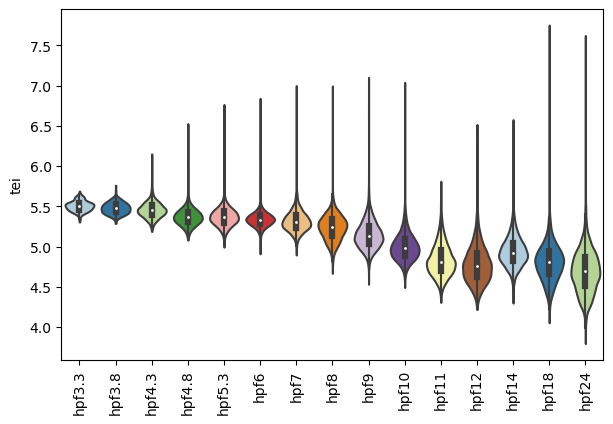

In [23]:
sc.pl.violin(adata=zebrafish_data,
             keys=['tei'],
             groupby='stage',
             rotation=90,
             palette='Paired',
             stripplot=False,
             inner='box')

### Boxplot gene age class per embryo stage and add significance

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

### Boxplot gene age class per embryo stage and per cell type

E.g. to just show the same plot for a selected cell-type, one could do the following.

1. List all annotated cell types:

In [24]:
list(set(zebrafish_data.obs['cell_type']))

['otic placode',
 'differentiating neurons',
 'myotome',
 'diencephalon (aplnr2+)',
 'xanthoblast',
 'roofplate',
 'anterior neural ridge',
 'endothelial',
 'neural plate posterior',
 'hindbrain',
 'mesoderm adaxial cells',
 'mesoderm lateral plate (tbx1+)',
 'hindbrain dorsal',
 'pronephric duct',
 'apoptotic like',
 'tailbud mesoderm',
 'erythroid',
 'mesoderm lateral plate (fli1a+)',
 'heart',
 'neural crest',
 'non dorsal margin involuted',
 'hatching gland',
 'floorplate',
 'EVL',
 'forerunner cells',
 'blood island',
 'endoderm',
 'macrophage',
 'lens placode',
 'differentiating neurons (rohon beard)',
 'tailbud spinal cord',
 'epiblast',
 'midbrain ventral',
 'gut',
 'optic primordium',
 'differentiating neurons (eomesa+)',
 'blastomere',
 'retina pigmented epithelium',
 'notochord',
 'neural anterior',
 'ionocyte',
 'pectoral fin field',
 'epidermal (gbx2+)',
 'lateral line primordium',
 'differentiating neurons (dlx1a+)',
 'pharyngeal arch',
 'optic cup',
 'mesoderm lateral pl

2. Loop over all cell types:

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

### Plot relative expression per gene age class per sample stage

In [25]:
zebrafish_data_rematrix_grouped = orthomap2tei.get_rematrix(
    adata=zebrafish_data,
    gene_id=query_orthomap['geneID'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    use='counts',
    var_type='mean',
    group_by_obs='stage',
    obs_fillna='__NaN',
    obs_type='mean',
    standard_scale=0,
    normalize_total=False,
    log1p=False,
    target_sum=1e6)
zebrafish_data_rematrix_grouped

stage,hpf3.3,hpf3.8,hpf4.3,hpf4.8,hpf5.3,hpf6,hpf7,hpf8,hpf9,hpf10,hpf11,hpf12,hpf14,hpf18,hpf24
ps,,,,,,,,,,,,,,,
3,0.764627,0.452638,0.142862,0.001721,0.380122,0.224183,0.524612,0.299151,0.241819,0.376386,0.006195,0.000000,0.676281,1.000000,0.734178
6,1.000000,0.702532,0.364521,0.216780,0.435340,0.464472,0.436425,0.354149,0.196598,0.267763,0.004041,0.000000,0.482738,0.556821,0.363077
8,1.000000,0.722409,0.304685,0.182404,0.349074,0.382232,0.282011,0.253519,0.114345,0.196848,0.002810,0.000000,0.480291,0.543904,0.292205
10,1.000000,0.724049,0.477937,0.321896,0.640406,0.600950,0.621149,0.462778,0.284198,0.369801,0.000000,0.004783,0.654803,0.703847,0.428387
11,1.000000,0.745656,0.239909,0.193283,0.439040,0.492023,0.605661,0.482770,0.271234,0.365134,0.007061,0.000000,0.616462,0.544566,0.250281
13,0.565458,0.300936,0.092829,0.000000,0.400772,0.167057,1.000000,0.575175,0.746551,0.501629,0.269569,0.195538,0.402782,0.516666,0.482190
14,1.000000,0.776757,0.328039,0.217414,0.385286,0.411845,0.289142,0.243457,0.141855,0.121814,0.017648,0.000000,0.196897,0.320734,0.140969
16,0.271341,0.214311,0.119503,0.301235,0.770699,0.308169,1.000000,0.496707,0.718377,0.304646,0.138408,0.000000,0.303058,0.486639,0.159045
18,0.735362,0.513225,0.523445,0.350157,0.703763,0.094025,1.000000,0.476336,0.692365,0.372660,0.377326,0.342647,0.000000,0.014490,0.007894


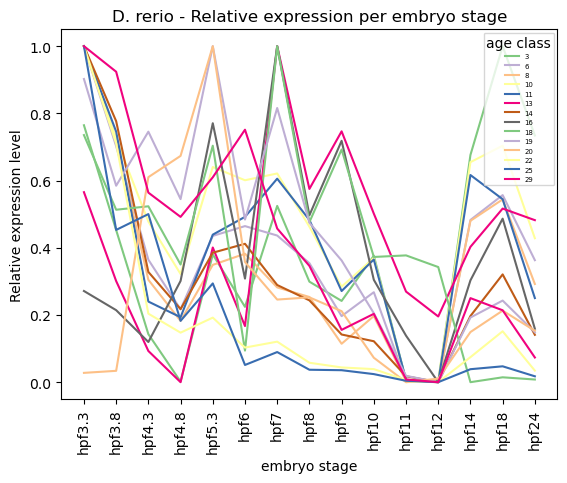

In [26]:
ax = sns.lineplot(zebrafish_data_rematrix_grouped.transpose(), palette='Accent', dashes=False)
ax.legend(fontsize=5, title='age class')
ax.set_title('D. rerio - Relative expression per embryo stage')
ax.set_xlabel('embryo stage')
ax.set_ylabel('Relative expression level')
#plt.tick_params(labelsize=3)
plt.xticks(rotation=90)
plt.show()

### Get partial TEI values to visualize gene age class contributions

Partial `TEI` values can give an idea about which gene age class contributed at most to the `global` `TEI` pattern.

In detail, each gene gets a `TEI` contribution profile as follows:

${TEI_is = f_is * ps_i}$

, where ${TEI_is}$ is the partial `TEI` value of gene ${i}$, ${f_is = e_is / \sum e_is}$ and ${ps_i}$ is the phylostratum of gene i.

${TEI_is}$ values are combined per ${ps}$.

The partial `TEI` values combined per strata give an overall impression of the contribution of each strata to the `global` `TEI` pattern.

One can either start from `counts` (`adata.X`) which is set as default or any other `layer` defined by the `layer` option (`layer=None`).

In addition, the `counts` can be `normalized` and `log-transformed` prior calculating partial `TEI` values (`normalize_total=False`, `log1p=False`, `target_sum=1e6`).

Further, these values can be combined per given observation, e.g. cell typer per sample timepoint (`group_by='cell_state'`).

The `get_pstrata` function of the `orthomap2tei` submodule will return two matrix, the first contains the sum of each partial `TEI` per gene age class and the second the corresponding frequencies.

Both can be further processed by returning the `cumsum` over the gene age classes. To get them set the option `cumsum=True`. The `cumsum` will result in either for the first matrix the `TEI` value per cell or mean `TEI` value per group, if one choose a observation with the `group_by` option. Or in case of the second frequency matrix will result in 1.

With the `standard_scale` option either gene age classes (`standard_scale=0` rows) or cells or groups (`standard_scale=1` columns) can be scaled, subtract the minimum and divide each by its maximum. By default no scaling is applied (`standard_scale=None`).

The resulting data will be visualized in the downstream section.

In [27]:
zebrafish_pstrata = orthomap2tei.get_pstrata(adata=zebrafish_data,
    gene_id=query_orthomap['geneID'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    cumsum=False,
    group_by_obs='stage',
    obs_fillna='__NaN',
    obs_type='mean',
    standard_scale=None,
    normalize_total=False,
    log1p=False,
    target_sum=1e6)
zebrafish_pstrata[0]

stage,hpf3.3,hpf3.8,hpf4.3,hpf4.8,hpf5.3,hpf6,hpf7,hpf8,hpf9,hpf10,hpf11,hpf12,hpf14,hpf18,hpf24
ps,,,,,,,,,,,,,,,
3,1.290495,1.297236,1.393324,1.452869,1.481578,1.373253,1.560257,1.538934,1.685917,1.716052,1.880050,1.900594,1.631686,1.722835,1.805536
6,2.437480,2.414509,2.245403,2.136051,2.068893,2.320190,1.929739,2.014335,1.739992,1.742832,1.470232,1.454718,1.919270,1.807139,1.701805
8,0.456443,0.461866,0.354579,0.332107,0.319230,0.361720,0.259364,0.286586,0.229340,0.250354,0.217498,0.214960,0.349400,0.325297,0.270581
10,0.562736,0.579016,0.632630,0.630602,0.629066,0.648687,0.573986,0.562863,0.498117,0.497728,0.388224,0.395077,0.555914,0.504074,0.457557
11,0.180120,0.191682,0.148295,0.171851,0.164644,0.190575,0.185744,0.192177,0.167168,0.168941,0.145734,0.142835,0.177265,0.138707,0.117511
13,0.165948,0.170210,0.187868,0.202844,0.225067,0.189695,0.333466,0.297236,0.391091,0.315743,0.381646,0.348969,0.192261,0.188965,0.238960
14,0.032577,0.034658,0.023931,0.022885,0.022671,0.025475,0.017005,0.017721,0.014679,0.012319,0.011481,0.009856,0.012259,0.014377,0.010946
16,0.016690,0.020220,0.026174,0.040815,0.041195,0.030307,0.044134,0.036813,0.050443,0.033808,0.042223,0.034821,0.022784,0.024279,0.021599
18,0.138576,0.126903,0.192006,0.169134,0.207968,0.058056,0.264774,0.171143,0.264336,0.181175,0.235274,0.217194,0.015727,0.016463,0.020860


corresponds to main Figure 1F

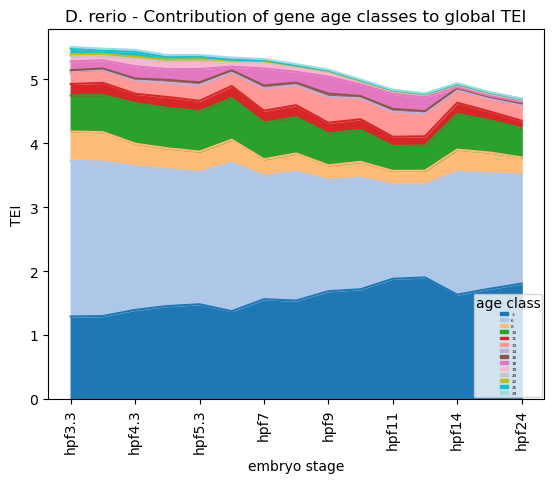

In [28]:
#plt.rcParams['figure.figsize'] = [9, 4.5]
ax=zebrafish_pstrata[0].transpose().plot.area(cmap='tab20')
ax.legend(fontsize=3, title='age class')
ax.set_title('D. rerio - Contribution of gene age classes to global TEI')
ax.set_xlabel('embryo stage')
ax.set_ylabel('TEI')
plt.xticks(rotation=90)
plt.show()
#plt.rcParams['figure.figsize'] = [6, 4.5]

### Gene age class contribution of one cell type

EVL:

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

hatiching gland:

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

endoderm:

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

### Color UMAP/TSNE by TEI

Follwoing the basic tutorial of the Scanpy python toolkit ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)), one can highlight `TEI` values on a dimensional reduction of the scRNA dataset, like `PCA`, `UMAP` or `TSNE`.

#### Filtering

In [29]:
sc.pp.filter_genes(zebrafish_data, min_cells=3)
sc.pp.filter_cells(zebrafish_data, min_genes=200)

#### Normalization, Log transformation and Scaling

In [30]:
sc.pp.normalize_total(zebrafish_data, target_sum=1e6)
sc.pp.log1p(zebrafish_data)
sc.pp.scale(zebrafish_data, max_value=10)

#### PCA and Neighbor calculations

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


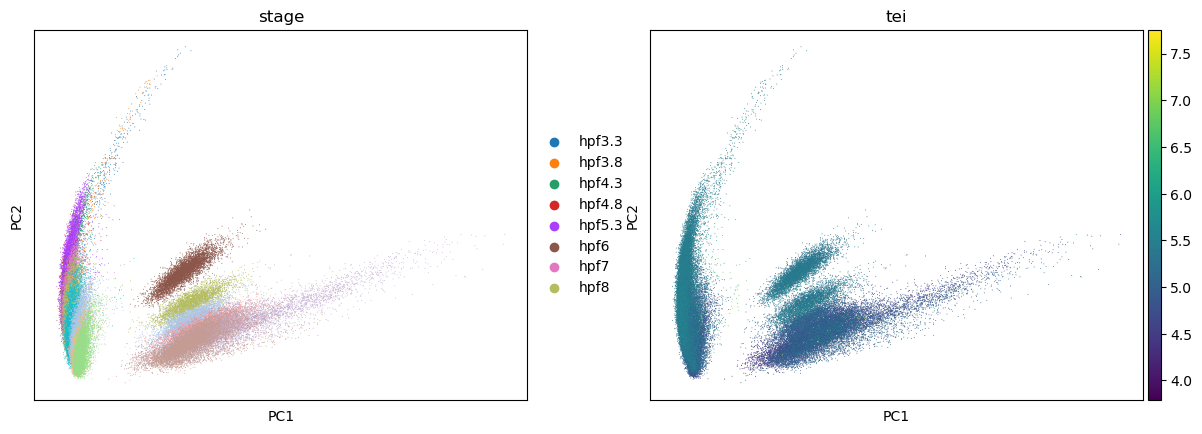

In [31]:
sc.tl.pca(zebrafish_data, svd_solver='arpack')
sc.pl.pca(zebrafish_data, color=['stage', 'tei'])

In [32]:
sc.pp.neighbors(zebrafish_data)

#### Embedding the neighborhood graph

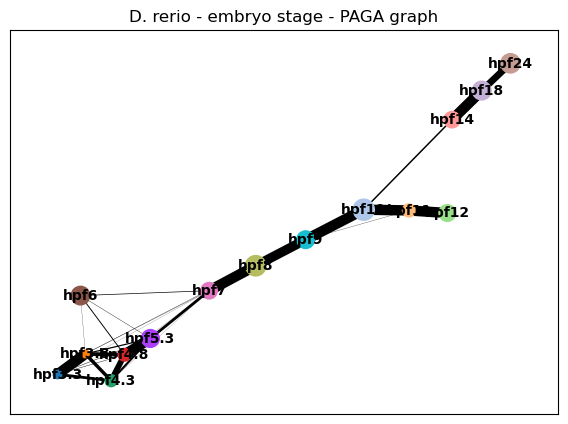

In [33]:
sc.tl.paga(zebrafish_data, groups='stage')
sc.pl.paga(zebrafish_data, title='D. rerio - embryo stage - PAGA graph')

#### UMAP

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


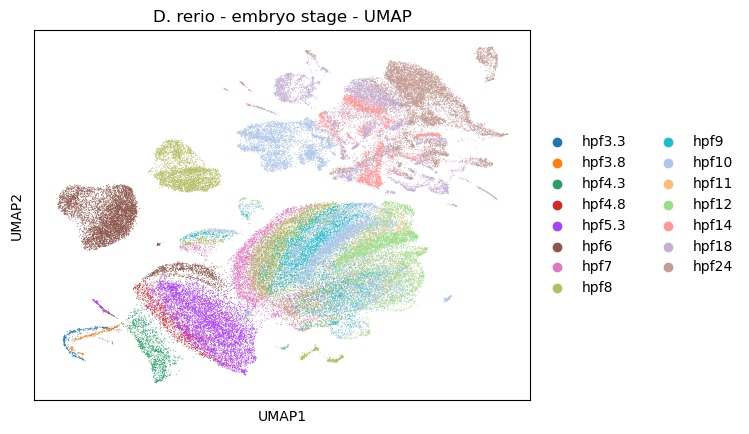

In [34]:
sc.tl.umap(zebrafish_data,
           init_pos='paga')
sc.pl.umap(zebrafish_data,
           title='D. rerio - embryo stage - UMAP', color=['stage'])

corresponds to main Figure 1G

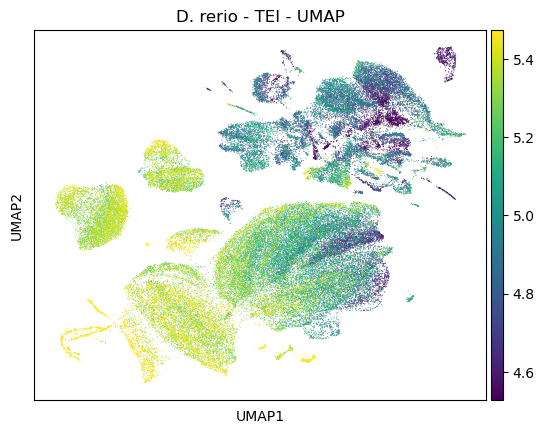

In [35]:
#plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(zebrafish_data,
           title='D. rerio - TEI - UMAP',
           color=['tei'],
           color_map='viridis',
           vmin='p5',
           vmax='p95')
#plt.rcParams['figure.figsize'] = [6, 4.5]